In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2, matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import gc

# LOAD DATA

In [2]:
DATA_PATH = '..//shopee-product-matching/'
train = pd.read_csv(DATA_PATH + 'train.csv')
train['image'] = DATA_PATH + 'train_images/' + train['image']
tmp = train.groupby('label_group').posting_id.agg('unique').to_dict()
train['target'] = train.label_group.map(tmp)
train = train.sort_values(by='label_group')
train.head()

,posting_id,image,image_phash,title,label_group,target
3874,train_1646767365,../input/shopee-product-matching/train_images/...,e925873ed09cd08f,Sarung celana wadimor original 100% dewasa dan...,258047,"[train_1646767365, train_398181303, train_1528..."
31859,train_1528423085,../input/shopee-product-matching/train_images/...,ea97861c926a71e3,WARNA RANDOM ACAK Sarung Celana Wadimor MURAH ...,258047,"[train_1646767365, train_398181303, train_1528..."
6738,train_398181303,../input/shopee-product-matching/train_images/...,e9b5833e929e909c,SARUNG CELANA WADIMOR DEWASA HITAM POLOS SARCEL,258047,"[train_1646767365, train_398181303, train_1528..."
7613,train_2865605743,../input/shopee-product-matching/train_images/...,bfc3cc1cc636c14c,Wall Sticker / WallSticker - Submarine Measur...,297977,"[train_2865605743, train_1382500866]"
12367,train_1382500866,../input/shopee-product-matching/train_images/...,838436c07dff19e4,RELIZA WALL STICKER PENGUKUR TINGGI BADAN JERA...,297977,"[train_2865605743, train_1382500866]"


# 1 Image Hash

* average hashing (aHash)
* perception hashing (pHash)
* difference hashing (dHash)
* wavelet hashing (wHash)



In [3]:
import imagehash
from PIL import Image

In [4]:
ahash = imagehash.average_hash(Image.open(train['image'].iloc[0]))
ahash

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [False, False,  True, False, False, False,  True,  True],
       [ True,  True, False, False, False, False,  True,  True],
       [ True,  True, False, False, False, False,  True,  True],
       [ True,  True, False, False, False, False, False,  True],
       [ True,  True, False, False, False, False, False,  True],
       [ True, False,  True,  True, False, False, False,  True],
       [ True,  True,  True,  True,  True,  True, False,  True]])

In [5]:
# conver to string
str(ahash)

'ff23c3c3c1c1b1fd'

In [6]:
print(str(imagehash.average_hash(Image.open(train['image'].iloc[0]))))
print(str(imagehash.phash(Image.open(train['image'].iloc[0]))))
print(str(imagehash.dhash(Image.open(train['image'].iloc[0]))))
print(str(imagehash.whash(Image.open(train['image'].iloc[0]))))

ff23c3c3c1c1b1fd
e925873ed09cd08f
6f4f171713232351
f703c3c3c1c181fd


image hash can calculate the distance by char edit distance. in below example, the hashs of sample group are differenet in some char.


In [7]:
print(str(imagehash.average_hash(Image.open(train['image'].iloc[0]))))
print(str(imagehash.average_hash(Image.open(train['image'].iloc[1]))))
print(str(imagehash.average_hash(Image.open(train['image'].iloc[2]))))

ff23c3c3c1c1b1fd
bfffe1c1c181f1fd
e7e3c3c3c1c181fd


# 2 Color Hist
color histogram is a representation of the distribution of colors in an image. For digital images, a color histogram represents the number of pixels that have colors in each of a fixed list of color ranges, that span the image's color space, the set of all possible colors.

In [8]:
img = cv2.imread(train['image'].iloc[0],0)

# https://docs.opencv.org/master/d1/db7/tutorial_py_histogram_begins.html
arr = cv2.calcHist([img],[0],None,[256],[0,256])
arr = arr.reshape(-1)
arr.shape

(256,)

Populating the interactive namespace from numpy and matplotlib


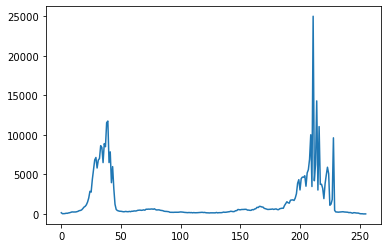

In [9]:
%pylab inline
plt.plot(range(256), arr)

color hist can calculate the distance by array distance. in below example, the hist of sample group are very similar.

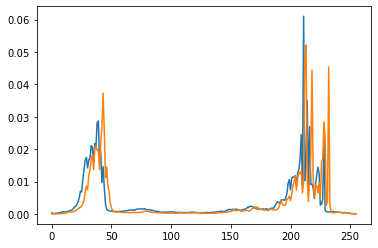

In [10]:
def cal_hist(path):
    img = cv2.imread(path,0)
    arr = cv2.calcHist([img],[0],None,[256],[0,256])
    arr = arr.reshape(-1)
    return arr / arr.sum()

plt.plot(range(256), cal_hist(train['image'].iloc[0]))
plt.plot(range(256), cal_hist(train['image'].iloc[2]))

# 3 Image Keypoint

Keypoint is a feature detection algorithm in computer vision to detect and describe local features in images. SIFT and ORB is common keypoint method, you can find they in OpenCV.

Keypoint is a local image feature, so count of keypoint may not same. And keypoint is easy attract by text in image.


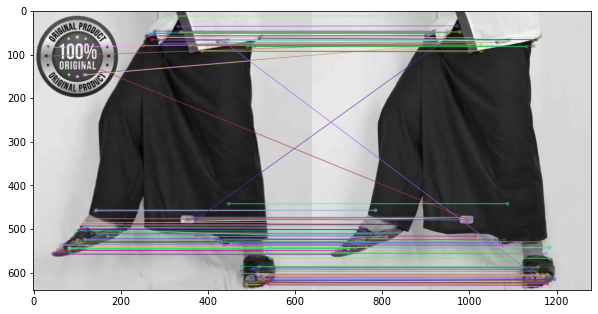

(<matplotlib.image.AxesImage at 0x7f4c8075f6d0>, None)

In [11]:
img1 = cv2.imread(train['image'].iloc[0], 0)          # queryImage
img2 = cv2.imread(train['image'].iloc[2], 0)          # trainImage

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

        # cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10, 7))
plt.imshow(img3),plt.show()


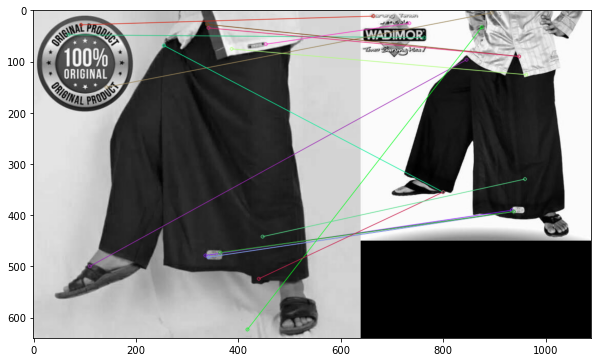

(<matplotlib.image.AxesImage at 0x7f4c806e1450>, None)

In [12]:
img1 = cv2.imread(train['image'].iloc[0], 0)          # queryImage
img2 = cv2.imread(train['image'].iloc[1], 0)          # trainImage

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

        # cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10, 7))
plt.imshow(img3),plt.show()


In [13]:
# a function for sift distance
def sift_match(path1, path2):
    img1 = cv2.imread(path1, 0)
    img2 = cv2.imread(path2, 0)
    
    # Initiate SIFT detector
    sift = cv2.SIFT_create(300)
    
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            good.append([m])

    return len(good)

In [14]:
# save group
sift_match(train[train['label_group'] == 249114794]['image'].iloc[0],
            train[train['label_group'] == 249114794]['image'].iloc[1])

40

In [15]:
# different group
sift_match(train[train['label_group'] == 249114794]['image'].iloc[0],
            train[train['label_group'] == 258047]['image'].iloc[1])

32

# 4 Deep Convnet(CNN)

Deep learning can do many things, include image classification and detection. In shopee compte, we can use CNN to calcuate the image feature (the internal output of CNN models).

And we can use pretrain models or custom models (train in Shopee dataset by your self).


In [16]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset

class ShopeeImageDataset(Dataset):
    def __init__(self, img_path, transform):
        self.img_path = img_path
        self.transform = transform
        
    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')
        img = self.transform(img)
        return img
    
    def __len__(self):
        return len(self.img_path)

In [17]:
imagedataset = ShopeeImageDataset(
    train['image'].values[:100],
    transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))
    
imageloader = torch.utils.data.DataLoader(
    imagedataset,
    batch_size=10, shuffle=False, num_workers=2
)

# pretrain models
class ShopeeImageEmbeddingNet(nn.Module):
    def __init__(self):
        super(ShopeeImageEmbeddingNet, self).__init__()
              
        model = models.resnet18(True)
        model.avgpool = nn.AdaptiveMaxPool2d(output_size=(1, 1))
        model = nn.Sequential(*list(model.children())[:-1])
        model.eval()
        self.model = model
        
    def forward(self, img):        
        out = self.model(img)
        return out

In [18]:
DEVICE = 'cpu'

imgmodel = ShopeeImageEmbeddingNet()
imgmodel = imgmodel.to(DEVICE)

imagefeat = []
with torch.no_grad():
    for data in tqdm_notebook(imageloader):
        data = data.to(DEVICE)
        feat = imgmodel(data)
        feat = feat.reshape(feat.shape[0], feat.shape[1])
        feat = feat.data.cpu().numpy()
        
        imagefeat.append(feat)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
from sklearn.preprocessing import normalize

# l2 norm to kill all the sim in 0-1
imagefeat = np.vstack(imagefeat)
imagefeat = normalize(imagefeat)

In [20]:
train.head(5)

,posting_id,image,image_phash,title,label_group,target
3874,train_1646767365,../input/shopee-product-matching/train_images/...,e925873ed09cd08f,Sarung celana wadimor original 100% dewasa dan...,258047,"[train_1646767365, train_398181303, train_1528..."
31859,train_1528423085,../input/shopee-product-matching/train_images/...,ea97861c926a71e3,WARNA RANDOM ACAK Sarung Celana Wadimor MURAH ...,258047,"[train_1646767365, train_398181303, train_1528..."
6738,train_398181303,../input/shopee-product-matching/train_images/...,e9b5833e929e909c,SARUNG CELANA WADIMOR DEWASA HITAM POLOS SARCEL,258047,"[train_1646767365, train_398181303, train_1528..."
7613,train_2865605743,../input/shopee-product-matching/train_images/...,bfc3cc1cc636c14c,Wall Sticker / WallSticker - Submarine Measur...,297977,"[train_2865605743, train_1382500866]"
12367,train_1382500866,../input/shopee-product-matching/train_images/...,838436c07dff19e4,RELIZA WALL STICKER PENGUKUR TINGGI BADAN JERA...,297977,"[train_2865605743, train_1382500866]"


In [21]:
# in this case, the group 258047 (the first three) have high confidence.
np.dot(imagefeat[0], imagefeat.T)[:5]

array([0.99999994, 0.9209987 , 0.96845776, 0.83772707, 0.8346508 ],
      dtype=float32)

In [22]:
# in this case, the group 297977 (the last two) have high confidence.
np.dot(imagefeat[3], imagefeat.T)[:5]

array([0.83772707, 0.83808064, 0.81704164, 1.        , 0.8924126 ],
      dtype=float32)